# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 20px; line-height: 1;border-radius:20px">Simple Audio Classification</div>
<div style="width:100%;text-align:center"> 
</div>

<div>
    <img src="image0.jfif" alt="Image 1" style="width: 45%; display: inline-block; margin-right: 100px;">
    <img src="image1.jfif" alt="Image 2" style="width: 45%; display: inline-block;">
</div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import librosa
import soundfile as sf

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

<a id="1"></a>
# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 14px; line-height: 1;border-radius:20px">Prepare the data</div>

In [2]:
def mp3_to_wav(input_file, output_file):
    y, sr = librosa.load(input_file, sr=None)

    sf.write(output_file, y, sr)

# def chunk_wav(input_file, output_folder, chunk_length=15, min_amplitude_threshold=0.05):
#     y, sr = librosa.load(input_file, sr=None)

#     # Calculate the number of samples for the desired chunk length
#     chunk_length_samples = int(chunk_length * sr)

#     # Split the audio into chunks and remove silent parts from each chunk
#     for i in range(0, len(y), chunk_length_samples):
#         chunk = y[i:i + chunk_length_samples]
#         # Remove silent parts from the chunk
#         trimmed_chunk, _ = librosa.effects.trim(chunk)
#         # Skip the chunk if it becomes too short after trimming
#         if len(trimmed_chunk) < chunk_length_samples // 2:
#             continue
#         # Check if the maximum amplitude of the trimmed chunk is above the threshold
#         if np.max(np.abs(trimmed_chunk)) < min_amplitude_threshold:
#             continue
#         chunk_file = os.path.join(output_folder, f"chunk_{i // sr}.wav")
#         sf.write(chunk_file, trimmed_chunk, sr)


# input_file = "audio 1.mp3"
# output_wav_file = "audio 1.wav"
# output_folder = "data/1"


# mp3_to_wav(input_file, output_wav_file)

# os.makedirs(output_folder, exist_ok=True)
# chunk_wav(output_wav_file, output_folder)

In [3]:
import random

def choose_random_audio_file(data_folder):
    # List subfolders in the data folder
    subfolders = os.listdir(data_folder)
    # Randomly choose a subfolder
    random_subfolder = random.choice(subfolders)
    # Get the path to the randomly chosen subfolder
    subfolder_path = os.path.join(data_folder, random_subfolder)
    # List all files in the randomly chosen subfolder
    files = os.listdir(subfolder_path)
    # Filter out non-audio files
    audio_files = [file for file in files if file.endswith(('.wav'))]
    if not audio_files:
        raise ValueError("No audio files found in the folder.")
    # Choose a random audio file from the filtered list
    random_audio_file = random.choice(audio_files)

    return os.path.join(subfolder_path, random_audio_file)

<a id="1"></a>
# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 14px; line-height: 1;border-radius:20px">Visualize the data</div>

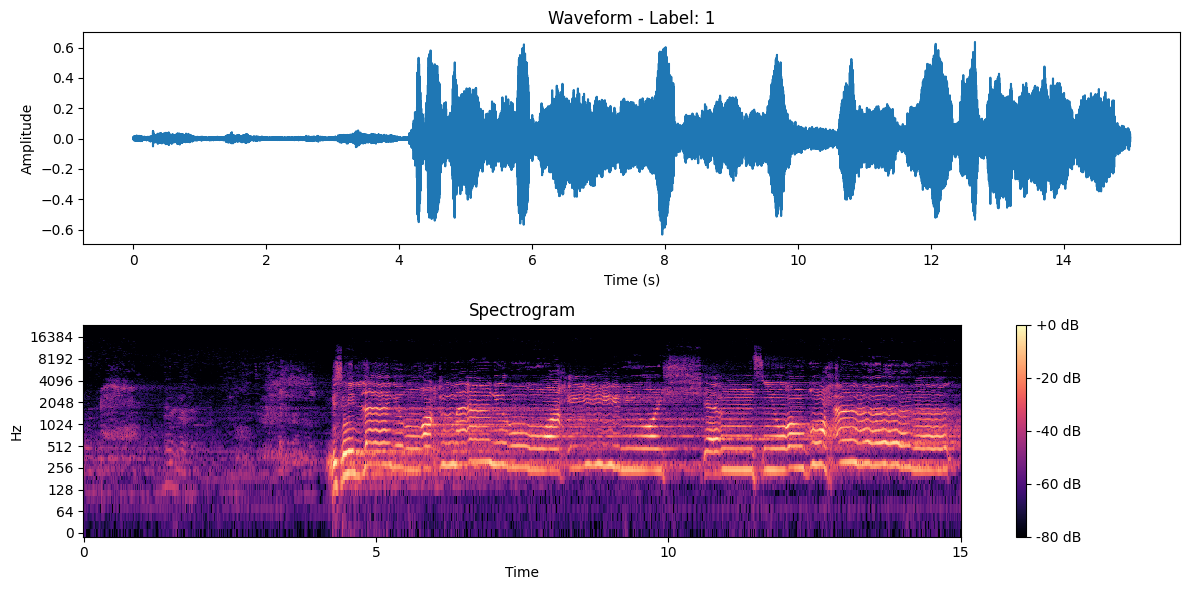

In [23]:
from IPython.display import Audio, display

data_folder = "data"
def visualize_audio(audio_file, label):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.title(f'Waveform - Label: {label}')
    plt.plot(np.arange(len(y)) / sr, y)  # Plot the waveform
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    plt.title('Spectrogram')
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
    

random_audio_file = choose_random_audio_file(data_folder)
label = os.path.basename(os.path.dirname(random_audio_file))
display(Audio(data=random_audio_file))
visualize_audio(random_audio_file, label)

<a id="1"></a>
# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 14px; line-height: 1;border-radius:20px">Extract the features</div>

In [5]:
def extract_features(file_path, mfcc, chroma, mel):
    with sf.SoundFile(file_path) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
    return result

In [6]:
data_dir = "data"  # Root folder containing subfolders for each class

# Create lists to store features and labels
data = []
labels = []

# Iterate through each folder (class)
for label, folder_name in enumerate(os.listdir(data_dir)):
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue  # Skip if not a directory
    # Extract features for each audio file in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if not file_name.endswith('.wav'):
            continue  # Skip non-wav files
        features = extract_features(file_path, mfcc=True, chroma=True, mel=True)
        data.append(features)
        labels.append(label)  # Assign label based on folder/class

In [7]:
# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

<a id="1"></a>
# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 14px; line-height: 1;border-radius:20px">Splite the data</div>

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.15, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.15, random_state=42)

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of val_data:", val_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)
print("Shape of val_labels:", val_labels.shape)

Shape of train_data: (160, 180)
Shape of test_data: (34, 180)
Shape of val_data: (29, 180)
Shape of train_labels: (160,)
Shape of test_labels: (34,)
Shape of val_labels: (29,)


<a id="1"></a>
# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 14px; line-height: 1;border-radius:20px">Build the NN Model</div>

In [15]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(train_data.shape[1],)),
    layers.Dropout(0.05),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(train_data, train_labels, epochs=9, batch_size=32, validation_data=(val_data, val_labels))

Epoch 1/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6355 - loss: 1.4765 - val_accuracy: 0.8621 - val_loss: 0.5993
Epoch 2/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7441 - loss: 1.0113 - val_accuracy: 0.9655 - val_loss: 0.0839
Epoch 3/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9121 - loss: 0.4052 - val_accuracy: 1.0000 - val_loss: 0.0361
Epoch 4/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9381 - loss: 0.2769 - val_accuracy: 0.9655 - val_loss: 0.0618
Epoch 5/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9023 - loss: 0.3610 - val_accuracy: 0.9655 - val_loss: 0.1256
Epoch 6/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9115 - loss: 0.2268 - val_accuracy: 0.9310 - val_loss: 0.1277
Epoch 7/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9306 - loss: 0.1969 - val_accuracy: 0.9655 - val_loss: 0.1253
Epoch 8/9
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9766 - loss: 0.1192 - val_accuracy: 0.9655 - val_loss: 0.1088
Epoch 9/

# The Model after trained on data😂❤️

<div>
    <img src="heart.jfif" alt="Image 1" style="width: 45%; display: inline-block; margin-right: 5px;">
</div>

<a id="1"></a>
# <div style="text-align: center; background-color: #de571d; font-family:Impact; color: white; padding: 14px; line-height: 1;border-radius:20px">Evaluate</div>

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9700 - loss: 0.0651 
Test accuracy: 0.970588207244873


In [26]:
display(Audio(data="test1.mp3"))

In [27]:
# Load the external audio file
input_file = "test1.mp3"
output_wav_file = "test1.wav"


mp3_to_wav(input_file, output_wav_file)
audio_data, sample_rate = librosa.load(output_wav_file, sr=None)

# Extract features from the audio file
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

# Concatenate the features
features = np.concatenate([mfccs, chroma, mel], axis=0)
features = np.mean(features, axis=1)  # Calculate mean along each feature dimension

# Reshape the features to match the input shape expected by the model
features = np.expand_dims(features, axis=0)

# Make predictions using the trained model
predictions = model.predict(features)

# Convert predictions to class labels
predicted_class = "الشيخ المنشاوي رحمة الله عليه" if predictions[0][0] < 0.5 else "الشيخ عبدالباسط رحمة الله عليه"
confidence = predictions[0][0]

print("Predicted class:", predicted_class)
print("Confidence:", f"{confidence:.12f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: الشيخ عبدالباسط رحمة الله عليه
Confidence: 0.998868644238
